In [28]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorboard.backend.event_processing import event_accumulator
import subprocess
import webbrowser
import os

In [29]:
def get_summary(save_path,prepend=""):
    ea = event_accumulator.EventAccumulator(save_path)
    if not os.path.exists(save_path):
        print("no save path found, returning empy dict...")
        return dict()
    ea.Reload()
    res = dict()
    for tag in ea.Tags()['scalars']:
        evs = ea.Scalars(tag)
        wall_time = [e.wall_time for e in evs]
        step = [e.step for e in evs]
        value = [e.value for e in evs]
        tag = prepend + tag
        res[tag] = value
        res[tag+"_step"] = step
        res[tag + "_wall_time"] = wall_time
    res[prepend + 'scalars'] = [prepend + t for t in ea.Tags()['scalars']]
    scalars = ea.Tags()['scalars']
    #print("> get_summary():%s*; got %i scalars %s" % (prepend, len(scalars), ", ".join(scalars)))

    drs = os.listdir(save_path)
    for d in drs:
        np = os.path.join(save_path, d)
        if os.path.isdir(np):
            res.update( get_summary(np, d+'/') )
    return res

In [30]:
logs = get_summary('C:\\Users\\elind\\Documents\\GitHub\\KillingDemons\\Plots\\data for Optimizers plot')

INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\A2C_0\events.out.tfevents.1557692000.AKSEL
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\A2C_1\events.out.tfevents.1557692000.AKSEL
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\A2C_2\events.out.tfevents.1557692000.AKSEL
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\A2C_3\events.out.tfevents.1557692000.AKSEL
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\basictrain_23_0\events.out.tfevents.1557867964.DESKTOP-FMLHC5U
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\basictrain_23_1\events.out.tfevents.1557867970.DESKTOP-FMLHC5U
INFO:tensorflow:No path 

INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_0\events.out.tfevents.1555556984.TOBIAS-PC
INFO:tensorflow:Directory watcher advancing from C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_1\events.out.tfevents.1555445852.TOBIAS-PC to C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_1\events.out.tfevents.1555529992.TOBIAS-PC
INFO:tensorflow:Directory watcher advancing from C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_1\events.out.tfevents.1555529992.TOBIAS-PC to C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_1\events.out.tfevents.1555556987.TOBIAS-PC
INFO:tensorflow:No path found after C:\Users\elind\Documents\GitHub\KillingDemons\Plots\data for Optimizers plot\train__lr=1e-05_bs=10_1\events.out.tf

In [31]:
def smootherfunc(kills_0,smooth_factor):
    while (len(kills_0) % smooth_factor != 0):
        kills_0= kills_0[:-1]
    kills_0avg=np.mean(kills_0.reshape(-1, smooth_factor), axis=1)
    kills_0std=np.std(kills_0.reshape(-1, smooth_factor), axis=1)/np.sqrt(smooth_factor)
    return(kills_0avg,kills_0std)

# If the arrays dont have the same length then mean over the ones we have.
def clipfunction(kills_0,kills_1,kills_2,kills_3):
    length=[len(kills_0),len(kills_1),len(kills_2),len(kills_3)]
    minlen=np.min(length)
    #index_min = np.argmin(length)
    return(kills_0[0:minlen],kills_1[0:minlen],kills_2[0:minlen],kills_3[0:minlen])

def avgkilltimereward(path, smooth_factor):
    string2=(path.split('_0'))
    stringname={}
    for i in range(0,4):
        stringname[i]=string2[0]+'_'+str(i)
    print(stringname[0])
    #kills_0 = 0#np.asarray(logs[str(stringname[0])+'/Perf/Kills'])
    #kills_1 = 0#np.asarray(logs[str(stringname[1])+'/Perf/Kills'])
    #kills_2 = 0#np.asarray(logs[str(stringname[2])+'/Perf/Kills'])
    #kills_3 = 0#np.asarray(logs[str(stringname[3])+'/Perf/Kills'])
    timealive_0 = np.asarray(logs[str(stringname[0])+'/Perf/Length'])
    timealive_1 = np.asarray(logs[str(stringname[1])+'/Perf/Length'])
    timealive_2 = np.asarray(logs[str(stringname[2])+'/Perf/Length'])
    timealive_3 = np.asarray(logs[str(stringname[3])+'/Perf/Length'])
    
    reward_0 = np.asarray(logs[str(stringname[0])+'/Perf/Reward'])
    reward_1 = np.asarray(logs[str(stringname[1])+'/Perf/Reward'])
    reward_2 = np.asarray(logs[str(stringname[2])+'/Perf/Reward'])
    reward_3 = np.asarray(logs[str(stringname[3])+'/Perf/Reward'])
    
    # the total number of frames used to train:
    timealive=np.sum([timealive_0.sum(),timealive_1.sum(),timealive_2.sum(),timealive_3.sum()])
    episodemean=(timealive_0[-20:-1].mean()+timealive_1[-20:-1].mean()+timealive_2[-20:-1].mean()+timealive_3[-20:-1].mean())/4
    #killsmean=(kills_0[-20:-1].mean()+kills_1[-20:-1].mean()+kills_2[-20:-1].mean()+kills_3[-20:-1].mean())/4
    print('Number of frames rendered='+str(timealive))
    print('Average time alive per episode in last 100 episodes='+str(episodemean))
    #print('Average kills episode in last 100 episodes='+str(killsmean))
    #[kills_0,kills_1,kills_2,kills_3]=clipfunction(kills_0,kills_1,kills_2,kills_3)
    [timealive_0,timealive_1,timealive_2,timealive_3]=clipfunction(timealive_0,timealive_1,timealive_2,timealive_3)
    [reward_0,reward_1,reward_2,reward_3]=clipfunction(reward_0,reward_1,reward_2,reward_3)
    
    
    timealivecum=np.sum([timealive_0.cumsum(),timealive_1.cumsum(),timealive_2.cumsum(),timealive_3.cumsum()],axis=0)
    
    [timealivecum,timealivecumstd]=smootherfunc(timealivecum,smooth_factor)
    
    
    #killsavg=np.mean([kills_0,kills_1,kills_2,kills_3],axis=0)
    #[killsavgsmoth,killsstd]=smootherfunc(killsavg,smooth_factor)
    
    timealiveavg=np.mean([timealive_0,timealive_1,timealive_2,timealive_3],axis=0)
    [timealiveavgsmoth,timealivestd]=smootherfunc(timealiveavg,smooth_factor)
    
    rewardavg=np.mean([reward_0,reward_1,reward_2,reward_3],axis=0)
    [rewardavgsmoth,rewardstd]=smootherfunc(rewardavg,smooth_factor)
    
    
    return(timealiveavgsmoth,timealivestd,timealivecum,rewardavgsmoth,rewardstd) #killsavgsmoth,killsstd,
    

In [32]:
def smootherfunc2C(kills_0,smooth_factor):
    while (len(kills_0) % smooth_factor != 0):
        kills_0= kills_0[:-1]
    kills_0avg=np.mean(kills_0.reshape(-1, smooth_factor), axis=1)
    kills_0std=np.std(kills_0.reshape(-1, smooth_factor), axis=1)/np.sqrt(smooth_factor)
    return(kills_0avg,kills_0std)

# If the arrays dont have the same length then mean over the ones we have.
def clipfunction2C(kills_0):
    length=len(kills_0)
    minlen=np.min(length)
    #index_min = np.argmin(length)
    return(kills_0[0:minlen])

def avgkilltimereward2C(path, smooth_factor):
    #string2=(path.split('_0'))
    #stringname={}
    #for i in range(0,4):
     #   stringname[i]=string2[0]+'_'+str(i)
    #print(stringname[0])
    #kills_0 = 0#np.asarray(logs[str(stringname[0])+'/Perf/Kills'])
    #kills_1 = 0#np.asarray(logs[str(stringname[1])+'/Perf/Kills'])
    #kills_2 = 0#np.asarray(logs[str(stringname[2])+'/Perf/Kills'])
    #kills_3 = 0#np.asarray(logs[str(stringname[3])+'/Perf/Kills'])
    timealive_0 = np.asarray(logs[str(path)+'/Perf/Length'])
    #timealive_1 = np.asarray(logs[str(stringname[1])+'/Perf/Length'])
    #timealive_2 = np.asarray(logs[str(stringname[2])+'/Perf/Length'])
    #timealive_3 = np.asarray(logs[str(stringname[3])+'/Perf/Length'])
    
    reward_0 = np.asarray(logs[str(path)+'/Perf/Reward'])
    #reward_1 = np.asarray(logs[str(stringname[1])+'/Perf/Reward'])
    #reward_2 = np.asarray(logs[str(stringname[2])+'/Perf/Reward'])
    #reward_3 = np.asarray(logs[str(stringname[3])+'/Perf/Reward'])
    
    # the total number of frames used to train:
    timealive=np.sum(timealive_0.sum())
    episodemean=(timealive_0[-20:-1].mean())
    #killsmean=(kills_0[-20:-1].mean()+kills_1[-20:-1].mean()+kills_2[-20:-1].mean()+kills_3[-20:-1].mean())/4
    print('Number of frames rendered='+str(timealive))
    print('Average time alive per episode in last 100 episodes='+str(episodemean))
    #print('Average kills episode in last 100 episodes='+str(killsmean))
    #[kills_0,kills_1,kills_2,kills_3]=clipfunction(kills_0,kills_1,kills_2,kills_3)
    timealive_0=clipfunction2C(timealive_0)
    reward_0=clipfunction2C(reward_0)
    
    
    timealivecum=np.sum(timealive_0.cumsum(),axis=0)
    
    [timealivecum,timealivecumstd]=smootherfunc2C(timealivecum,smooth_factor)
    
    
    #killsavg=np.mean([kills_0,kills_1,kills_2,kills_3],axis=0)
    #[killsavgsmoth,killsstd]=smootherfunc(killsavg,smooth_factor)
    
    timealiveavg=np.mean([timealive_0],axis=0)
    [timealiveavgsmoth,timealivestd]=smootherfunc2C(timealiveavg,smooth_factor)
    
    rewardavg=np.mean([reward_0],axis=0)
    [rewardavgsmoth,rewardstd]=smootherfunc2C(rewardavg,smooth_factor)
    
    
    return(timealiveavgsmoth,timealivestd,timealivecum,rewardavgsmoth,rewardstd) #killsavgsmoth,killsstd,
    

In [33]:
def mergeab(timealiveR99a,timealiveR99stda,framesR99a,rewardR99a,rewardR99stda, timealiveR99b,timealiveR99stdb,framesR99b,rewardR99b,rewardR99stdb):
        print(timealiveR99a)
        timealiveR99 = np.concatenate((timealiveR99a, timealiveR99b))
        timealiveR99std = np.concatenate((timealiveR99stda, timealiveR99stdb))
        framesR99 = np.concatenate((framesR99a, framesR99b+278552.99950408936))
        rewardR99 = np.concatenate((rewardR99a, rewardR99b))
        rewardR99std = np.concatenate((rewardR99stda, rewardR99stdb))
        
        return (timealiveR99,timealiveR99std,framesR99,rewardR99,rewardR99std)

In [65]:

# The smoothing factor 
smooth_factor=50 # from 1 to alot...
# Filepath of the folders which ends with : _0 , it fill load the rest of the agents, and average over them..
[timealiveA4,timealiveA4std,framesA4,rewardA4,rewardA4std]=avgkilltimereward('basictrain_23_0',smooth_factor) #kills10,kills10std,
[timealiveA5,timealiveA5std,framesA5,rewardA5,rewardA5std]=avgkilltimereward('basictrain_3_0',smooth_factor) #kills10,kills10std,
[timealiveA6,timealiveA6std,framesA6,rewardA6,rewardA6std]=avgkilltimereward('basictrain_5_0',smooth_factor) #kills10,kills10std,
baseline=(timealiveA4[0]+timealiveA5[0]+timealiveA6[0])/3


basictrain_23_0
Number of frames rendered=746957.7996063232
Average time alive per episode in last 100 episodes=97.07105231285095
basictrain_3_0
Number of frames rendered=178993.59993171692
Average time alive per episode in last 100 episodes=15.702631523734645
basictrain_5_0
Number of frames rendered=450580.399851799
Average time alive per episode in last 100 episodes=20.44999999749033


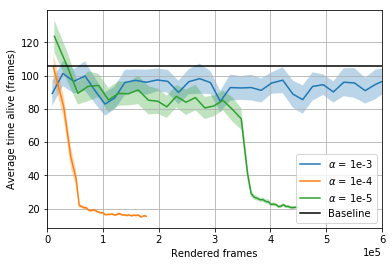

In [66]:

figure1=plt.figure()
#figsize=(6, 6)
plt.plot(framesA4,timealiveA4,label=r'$\alpha$ = 1e-3')
plt.fill_between(framesA4,timealiveA4+2*timealiveA4std,timealiveA4-2*timealiveA4std,alpha=0.3)

plt.plot(framesA5,timealiveA5,label=r'$\alpha$ = 1e-4')
plt.fill_between(framesA5,timealiveA5+2*timealiveA5std,timealiveA5-2*timealiveA5std,alpha=0.3)

plt.plot(framesA6,timealiveA6,label=r'$\alpha$ = 1e-5')
plt.fill_between(framesA6,timealiveA6+2*timealiveA6std,timealiveA6-2*timealiveA6std,alpha=0.3)
plt.axhline(baseline, 0,1, color = 'k', label = 'Baseline')

#plt.plot(framesR8/2,timealiveR8*2,label='RMSProp(lr = 1e-4, decay = 0.8)')
#plt.fill_between(framesR8/2,timealiveR8*2+2*timealiveR8std,timealiveR8*2-2*timealiveR8std,alpha=0.3)

#plt.plot(framesR9/2,timealiveR9*2,label='RMSProp(lr = 1e-4, decay = 0.9)')
#plt.fill_between(framesR9/2,timealiveR9*2+2*timealiveR9std,timealiveR9*2-2*timealiveR9std,alpha=0.3)

#plt.plot(framesR99/2,timealiveR99*2,label='RMSProp(lr = 1e-4, decay = 0.99)')
#plt.fill_between(framesR99/2,timealiveR99*2+2*timealiveR99std,timealiveR99*2-2*timealiveR99std,alpha=0.3)

plt.ylabel('Average time alive (frames)')
plt.xlabel('Rendered frames')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([0,600000])
plt.legend()

plt.grid()

# Save the plot the next cell.

In [63]:
figure1.savefig("Basic2.pdf", bbox_inches='tight')

In [11]:
plt.figure()
#plt.plot(frames50,timealive50,label='Batch size 100')
#plt.fill_between(frames50,timealive50+2*timealive50std,timealive50-2*timealive50std,alpha=0.3)
plt.plot(frames100,timealive100,label='Time alive')


NameError: name 'frames100' is not defined

<Figure size 432x288 with 0 Axes>